# Math 2306: ODE Early-Semester Grade Analysis and Course Success Prediction

## Data description
Early-semester grade data collected over (at least) five semesters of Math 2306 students at Kennesaw State University.
Data include (for each student):
- Semester
- Four homework sets
- Three quizzes
- One midterm

From these data, the following are calculated:
- Homework average
- Quiz average
- Weighted course average, as follows: 10*(HW average) + 25*(Quiz average) + 65*(Midterm 1 score)

The final course letter grade for each student is stored as a target variable for prediction: students who earn an A, B, or C are labeled with a 1 (for passed) and students who earn a D or F are labeled with a 0 (for failed). 

**Important**: Dataset only includes grade data from students who finished the semester. Students who withdrew from the course are excluded.

In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score, precision_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')


# Prepare data

In [2]:
#Import data and choose predictors
grade_data = pd.read_excel('Grade_data/ODE_Grade_Data.xlsx')

#Keep only early grade data
early_data = grade_data[['Semester', 'HW1', 'HW2', 'HW3', 'HW4', 'Quiz1', 'Quiz2', 'Quiz3', 'Midterm1', 'Course_Grade']]
#Insert quiz and homework averages (normalized between 0 and 1)
early_data.insert(5, 'HW Avg',early_data[['HW1','HW2','HW3','HW4']].mean(axis=1)/10)
early_data.insert(9, 'Quiz Avg',early_data[['Quiz1','Quiz2','Quiz3']].mean(axis=1)/10)

#y is the target vector: 0 if the student failed, 1 if they passed
y = 1 - ((grade_data['Course_Grade'] == 'D') + (grade_data['Course_Grade'] == 'F'))*1

early_data.insert(loc = len(early_data.columns), column = 'Pass', value = y)

# Delete grade_data if space is a problem (shouldn't matter since grade_data isn't too big)
# del grade_data


# Exploratory Data Analysis

In [3]:
print(f'There are {len(y)} data points in the dataset.')
print('Here are a random sample of 5 data points:')
early_data.sample(5)

There are 174 data points in the dataset.
Here are a random sample of 5 data points:


,Semester,HW1,HW2,HW3,HW4,HW Avg,Quiz1,Quiz2,Quiz3,Quiz Avg,Midterm1,Course_Grade,Pass
148,D,10,10,10,10,1.00,6.000000,8,2,0.533333,0.666667,C,1
6,A,0,10,10,10,0.75,0.000000,0,0,0.000000,0.850000,C,1
32,A,10,10,10,10,1.00,7.000000,9,8,0.800000,0.950000,A,1
89,C,10,10,10,10,1.00,0.916667,7,10,0.597222,0.888889,B,1
60,B,10,10,10,10,1.00,7.000000,10,3,0.666667,0.410256,F,0


In [4]:
print('Let''s look at the correlation matrix for the numerical features:')
early_data.corr(numeric_only=True)

Lets look at the correlation matrix for the numerical features:


,HW1,HW2,HW3,HW4,HW Avg,Quiz1,Quiz2,Quiz3,Quiz Avg,Midterm1,Pass
HW1,1.000000,0.253373,0.361497,0.394416,0.696191,0.189396,0.191786,0.200634,0.263491,0.031429,0.125740
HW2,0.253373,1.000000,0.154089,0.487146,0.697526,0.087459,0.128916,0.156878,0.166044,0.044206,0.216727
HW3,0.361497,0.154089,1.000000,0.282241,0.629549,0.174120,0.052850,0.093918,0.149261,0.110683,0.131569
HW4,0.394416,0.487146,0.282241,1.000000,0.779491,0.097025,-0.018270,0.057985,0.063641,0.083527,0.169171
HW Avg,0.696191,0.697526,0.629549,0.779491,1.000000,0.191931,0.124251,0.179998,0.225561,0.096318,0.231919
Quiz1,0.189396,0.087459,0.174120,0.097025,0.191931,1.000000,0.445091,0.143003,0.761957,0.326459,0.315997
Quiz2,0.191786,0.128916,0.052850,-0.018270,0.124251,0.445091,1.000000,0.313793,0.806652,0.365008,0.364305
Quiz3,0.200634,0.156878,0.093918,0.057985,0.179998,0.143003,0.313793,1.000000,0.618660,0.482089,0.360789
Quiz Avg,0.263491,0.166044,0.149261,0.063641,0.225561,0.761957,0.806652,0.618660,1.000000,0.524909,0.470391
Midterm1,0.031429,0.044206,0.110683,0.083527,0.096318,0.326459,0.365008,0.482089,0.524909,1.000000,0.661899


**Brief analysis**:
From the above correlation matrix, it seems HW Avg, Quiz Avg, and Midterm1 correlate most with the target variable Pass.
Let's limit our search to these three explanatory variables. Next, we'll calculate the [variance inflation factor](https://en.wikipedia.org/wiki/Variance_inflation_factor) (VIF) of there variables to determine if we need all of them.

In [5]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

#Choose the data to use for prediction
X = early_data[['HW Avg', 'Midterm1', 'Quiz Avg']]

# VIF dataframe
vif = pd.DataFrame()
vif["Feature"] = X.columns

# calculating VIF for each feature
vif["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]

vif

,Feature,VIF
0,HW Avg,15.618070
1,Midterm1,20.651488
2,Quiz Avg,16.926606


**Brief analysis**:
The above table of VIF values suggests that the three variables are highly correlated and we only need one of them in a logistic regression model.
Instead of using only one category of grade, I'll instead use the weighted course average 0.1*(HW Avg) + 0.25*(Quiz Avg) + 0.65*Midterm1

In [6]:
if 'Weighted Avg' not in X.columns:
    X.insert(loc = len(X.columns), column = 'Weighted Avg', value = 0.1*X['HW Avg'] + 0.25*X['Quiz Avg'] + 0.65*X['Midterm1'])

In [7]:
print('One more look at the correlation matrix. Shouldn''t be surprising that the features are highly correlated:')
X.corr()

One more look at the correlation matrix. Shouldnt be surprising that the features are highly correlated:


,HW Avg,Midterm1,Quiz Avg,Weighted Avg
HW Avg,1.000000,0.096318,0.225561,0.245354
Midterm1,0.096318,1.000000,0.524909,0.948883
Quiz Avg,0.225561,0.524909,1.000000,0.754401
Weighted Avg,0.245354,0.948883,0.754401,1.000000


# Plot grade distributions

Here we''ll visualize histograms of letter grades (A,B,C,D,F) and of class success (pass/fail).

Then we'll look at course success as a function of each variable in the dataframe X above (HW Avg, Quiz Avg, Midterm1, Weighted Avg) and in two-dimensions as a function of Quiz Avg *and* Midterm1.

Text(0.75, 0.9, 'N = 174')

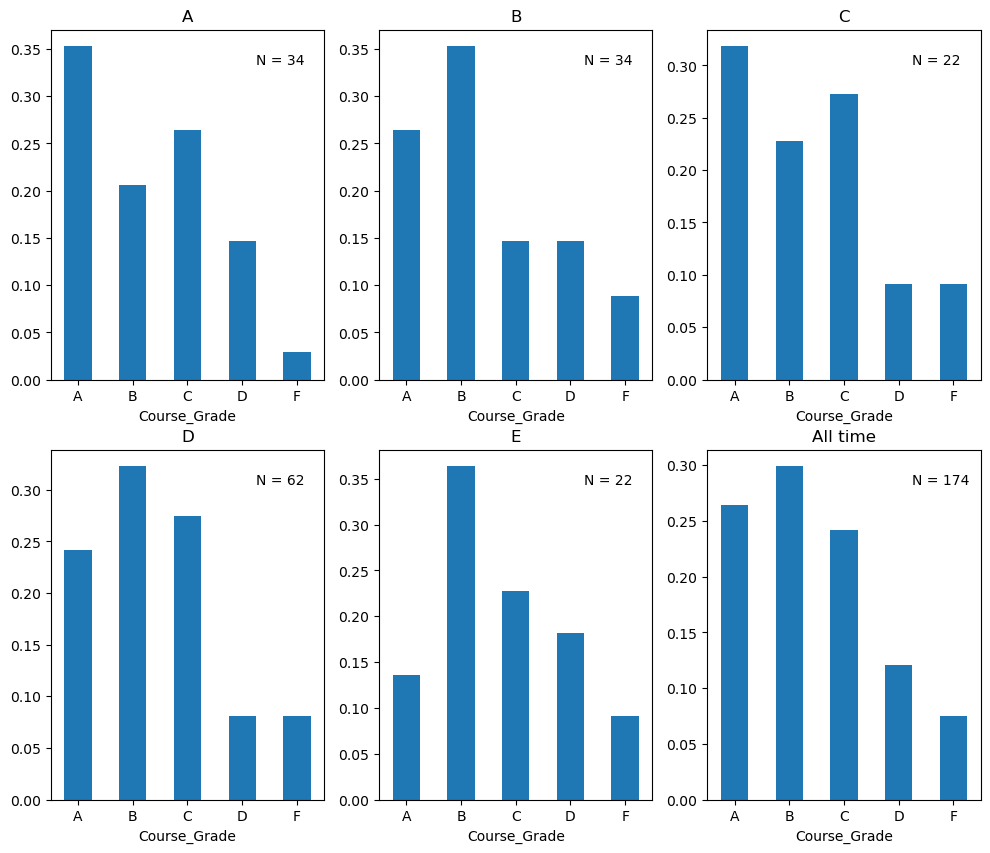

In [8]:
# Plot histograms of course letter grades

semesters = early_data.groupby('Semester').Course_Grade.value_counts(sort=False).index.unique(level='Semester').tolist()

grade_hists = early_data.groupby('Semester').Course_Grade.value_counts(sort=False)
total_grade_hist = grade_hists.groupby('Course_Grade').sum()
num_grades = grade_hists.groupby('Semester').sum()

'''
# UNCOMMENT TO GET ABSOLUTE VALUE HISTOGRAMS (instead of relative)
fig, axes = plt.subplots(2, 3)
for i, semester in enumerate(semesters):
    grade_hists.loc[semester].plot(kind='bar', rot=0, ax=axes[math.floor(i/3),i%3], title=semester, figsize=(12,10))
  
total_grade_hist.plot(kind='bar', rot=0, ax=axes[1,2], title='All time', figsize=(12,10))
'''
fig, axes = plt.subplots(2, 3)

for i, semester in enumerate(semesters):
    grade_hists.loc[semester].apply(lambda x: x/grade_hists.loc[semester].sum()).plot(kind='bar', rot=0, ax=axes[math.floor(i/3), i%3], title='Semester ' + semester, figsize=(12,10))
    axes[math.floor(i/3), i%3].text(0.75,0.9,f'N = {num_grades[semester]}',transform=axes[math.floor(i/3), i%3].transAxes)

total_grade_hist.apply(lambda x: x/grade_hists.sum()).plot(kind='bar', rot=0, ax=axes[1,2], title='All time', figsize=(12,10))
axes[1, 2].text(0.75,0.9,f'N = {num_grades.sum()}',transform=axes[1, 2].transAxes)

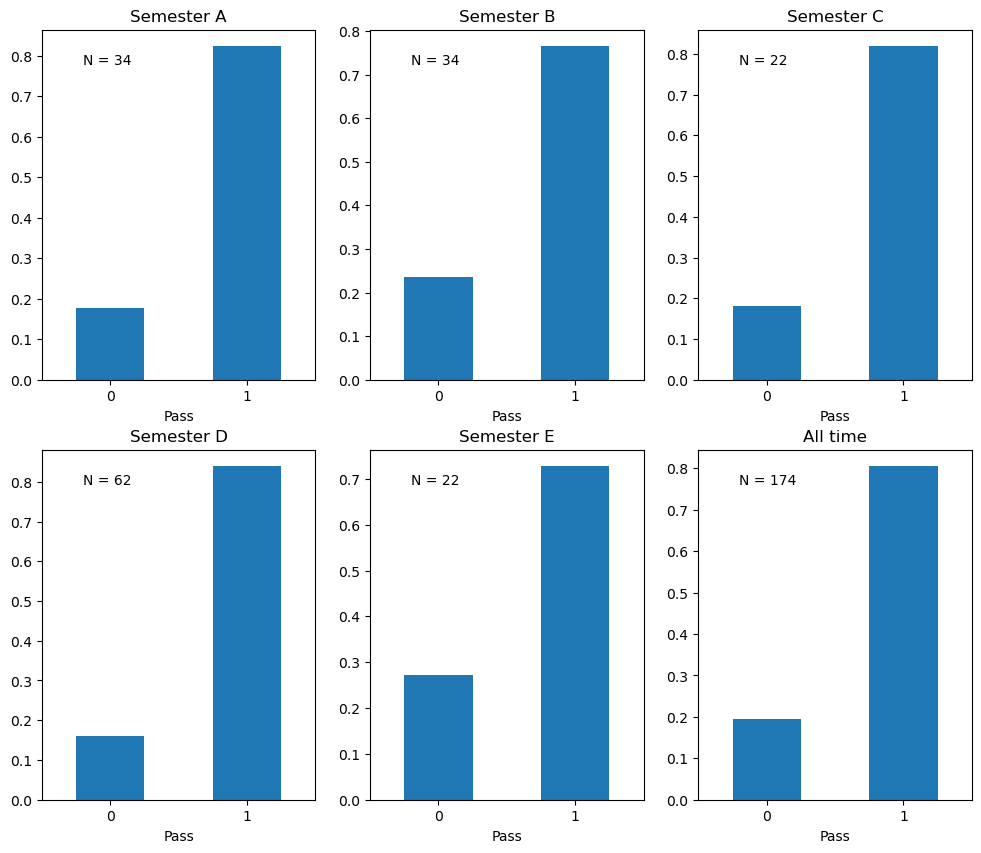

In [32]:
# Plot pass/fail histograms

semesters = early_data.groupby('Semester').Pass.value_counts(sort=False).index.unique(level='Semester').tolist()

pass_hists = early_data.groupby('Semester').Pass.value_counts(sort=False)
total_pass_hist = early_data.Pass.value_counts().sort_index()
num_grades = pass_hists.groupby('Semester').sum()

fig, axes = plt.subplots(2, 3)
for i, semester in enumerate(semesters):
    pass_hists.loc[semester].apply(lambda x: x/pass_hists.loc[semester].sum()).plot(kind='bar', rot=0, ax=axes[math.floor(i/3),i%3], title='Semester ' + semester, figsize=(12,10))
    axes[math.floor(i/3), i%3].text(0.15,0.9,f'N = {num_grades[semester]}',transform=axes[math.floor(i/3), i%3].transAxes)
  
total_pass_hist.apply(lambda x: x/pass_hists.sum()).plot(kind='bar', rot=0, ax=axes[1,2], title='All time', figsize=(12,10))
axes[1, 2].text(0.15,0.9,f'N = {num_grades.sum()}',transform=axes[1, 2].transAxes)
plt.show()

**Brief analysis**:
Data is quite imbalanced; should set class_weight to 'balanced' in logistic regression models

### Visualize pass/fail as a function of each feature in the X dataframe

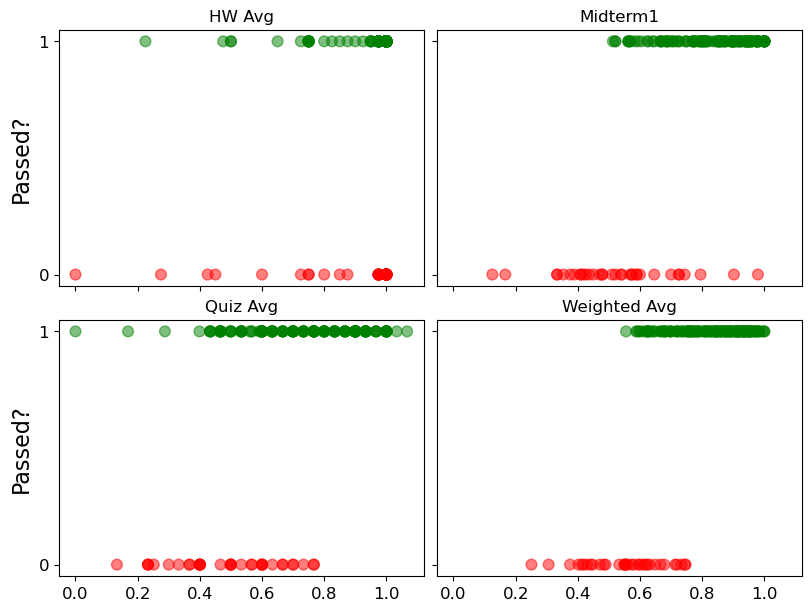

In [10]:
fig, axes = plt.subplots(2, 2, figsize=(8,6), sharey=True, sharex=True, constrained_layout=True)
colormap = np.array(['r', 'g'])

for i, column in enumerate(X.columns):
    axes[math.floor(i/2), i%2].scatter(X[column],y,c=colormap[y.values],alpha=0.5,s=60)
    axes[math.floor(i/2), i%2].set(title=column)
    axes[math.floor(i/2), i%2].set_yticks([0, 1])
    axes[math.floor(i/2), i%2].tick_params(axis = 'both', labelsize=12)
    if i%2==0:
        axes[math.floor(i/2), i%2].set_ylabel('Passed?', fontsize=16)

#fig.supylabel('Passed?',x=0.04, fontsize=16)
#fig.tight_latout()
#plt.ylabel('Passed?', fontsize = 18)
#plt.xticks(fontsize = 18)
#plt.yticks([0, 1], fontsize = 18)


**Brief analysis**: HW Avg does not seem to be a good predictor of student success in this course. This makes sense, since HW is grade for completion only and consequently does not provide a good indication if a student understand the material. Weighted Avg seems to separate the two outcomes the best of the four.

Next, we''ll plot student success as a function of both Quiz Avg *and* Midterm1

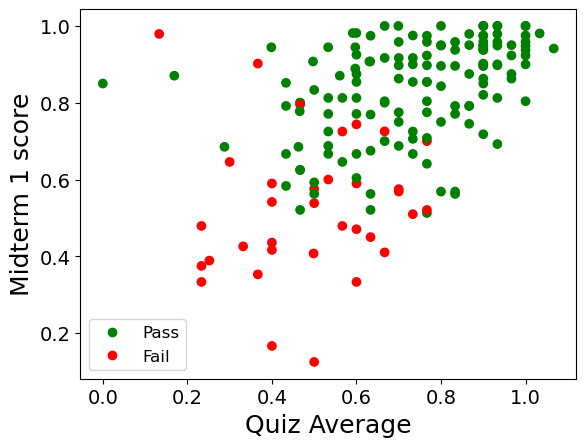

In [11]:
from matplotlib.colors import ListedColormap
colormap = ListedColormap(['r', 'g'])
scatter = plt.scatter(X['Quiz Avg'], X['Midterm1'],c=y.values,cmap=colormap)
plt.xlabel('Quiz Average', fontsize = 18)
plt.ylabel('Midterm 1 score', fontsize = 18)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.legend(handles=scatter.legend_elements()[0][::-1], labels=['Pass','Fail'], fontsize=12)
plt.show()


# Training Model(s)

Models will include
1. HW Avg, Quiz Avg, Midterm1
2. Quiz Avg, Midterm1
3. Midterm1
4. Weighted Avg

Models will be evaluated using accuracy as the primary metric. Will also consider recall and precision.

In [12]:
def model_train(X, y, features_list, balance = None):
    '''
    Define and train a logistic regression model to predict course outcome using the features in features_list 
    Arguments:
        X - dataframe of features
        y - series of target variable
        features_list - list of column names from X to be used to train the logistic regression classifier
        balance - None or 'balanced' -- used in the class_weight argument in LogisticRegression.
    Outputs:
        Trained classifier, X_test, y_test
    '''
    X_train, X_test, y_train, y_test = train_test_split(X[features_list], y, random_state=0)


    lr = LogisticRegression(class_weight=balance,random_state=0)
    params = {'C':[0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10]}#, 'gamma':[0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10]} 

    clf = GridSearchCV(lr, params, scoring = 'accuracy')
    clf.fit(X_train, y_train)

    return clf.best_estimator_, X_test, y_test


In [13]:
def model_eval(model, X_test, y_test, features_list, balance = None):
    y_prob = model.predict_proba(X_test)[:,1]
    y_pred = (y_prob > 0.5)*1

    if balance is None:
        balance_string = 'no'
    else:
        balance_string = 'balanced'

    print(f'For logistic regression classifier trained on {features_list} with {balance_string} class weighting:')
    print(f'Classification report:\n {classification_report(y_test,y_pred)}')
    print(f'ROC_AUC score: {roc_auc_score(y_test, y_prob):.3}')

In [14]:
# Some functions to plot and analyze precision-recall curves

def optimal_threshold(precision, recall, thresholds):

    '''
    Takes in the precision, recall, and thresholds returned by sk.metrics.precision_recall_curve and determines the (precision, recall)
    pair closest to (1,1). Also returns the optimal threshold and the index of the optimal threshold in the thresholds array

    Arguments:
        precision, recall, thresholds -- output of sk.metrics.precision_recall_curves
    Returns
        precision[opt_ind] -- precision value in the pair (precision, recall) closest to the point (1,1)
        recall[opt_ind] -- recall value in the pair (precision, recall) closest to the point (1,1)
        thresholds[opt_ind] -- threshold value corresponding to the optimal (precision, recall) values above
        opt_ind -- index of the optimal threshold in the thresholds array
    '''
    opt_ind = np.argmin((precision-1)**2 + (recall-1)**2)

    return precision[opt_ind], recall[opt_ind], thresholds[opt_ind], opt_ind

def plot_precision_recall_curve(precision, recall, thresholds):

    '''
    Print the precision-recall curve from classifier predictions with the optimal threshold
    as defined in optimal_threshold() indicated

    Arguments:
        precision, recall, thresholds -- output of sk.metrics.precision_recall_curves
    Returns:
        None
    '''

    _, _, _, opt_thresh = optimal_threshold(precision, recall, thresholds)


    plt.figure()
    plt.plot(recall, precision)
    plt.plot(recall[opt_thresh], precision[opt_thresh],'ok',markersize=10)
    plt.xlabel('recall')
    plt.ylabel('precision')
    plt.show()
    
    return None

In [15]:
all_features = ['HW Avg', 'Midterm1', 'Quiz Avg']
lr_all, X_test, y_test = model_train(X, y, all_features, balance=None)
model_eval(lr_all, X_test, y_test, all_features)

print('\n\n')
lr_all, X_test, y_test = model_train(X, y, all_features, balance='balanced')
model_eval(lr_all, X_test, y_test, all_features, balance='balanced')


For logistic regression classifier trained on ['HW Avg', 'Midterm1', 'Quiz Avg'] with no class weighting:
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.70      0.82        10
           1       0.92      1.00      0.96        34

    accuracy                           0.93        44
   macro avg       0.96      0.85      0.89        44
weighted avg       0.94      0.93      0.93        44

ROC_AUC score: 0.956



For logistic regression classifier trained on ['HW Avg', 'Midterm1', 'Quiz Avg'] with balanced class weighting:
Classification report:
               precision    recall  f1-score   support

           0       0.60      0.90      0.72        10
           1       0.97      0.82      0.89        34

    accuracy                           0.84        44
   macro avg       0.78      0.86      0.80        44
weighted avg       0.88      0.84      0.85        44

ROC_AUC score: 0.944


In [16]:
some_features = ['Midterm1', 'Quiz Avg']
lr_some, X_test_some, y_test_some = model_train(X, y, some_features, balance=None)
model_eval(lr_some, X_test_some, y_test_some, some_features)

print('\n\n')
lr_some_weighted, X_test_some_weighted, y_test_some_weighted = model_train(X, y, some_features, balance='balanced')
model_eval(lr_some_weighted, X_test_some_weighted, y_test_some_weighted, some_features, balance='balanced')

For logistic regression classifier trained on ['Midterm1', 'Quiz Avg'] with no class weighting:
Classification report:
               precision    recall  f1-score   support

           0       0.88      0.70      0.78        10
           1       0.92      0.97      0.94        34

    accuracy                           0.91        44
   macro avg       0.90      0.84      0.86        44
weighted avg       0.91      0.91      0.91        44

ROC_AUC score: 0.941



For logistic regression classifier trained on ['Midterm1', 'Quiz Avg'] with balanced class weighting:
Classification report:
               precision    recall  f1-score   support

           0       0.56      0.90      0.69        10
           1       0.96      0.79      0.87        34

    accuracy                           0.82        44
   macro avg       0.76      0.85      0.78        44
weighted avg       0.87      0.82      0.83        44

ROC_AUC score: 0.932


In [17]:
mid_features = ['Midterm1']
lr_mid, X_test, y_test = model_train(X, y, mid_features, balance=None)
model_eval(lr_mid, X_test, y_test, mid_features)

print('\n\n')
lr_mid, X_test, y_test = model_train(X, y, mid_features, balance='balanced')
model_eval(lr_mid, X_test, y_test, mid_features, balance='balanced')

For logistic regression classifier trained on ['Midterm1'] with no class weighting:
Classification report:
               precision    recall  f1-score   support

           0       0.88      0.70      0.78        10
           1       0.92      0.97      0.94        34

    accuracy                           0.91        44
   macro avg       0.90      0.84      0.86        44
weighted avg       0.91      0.91      0.91        44

ROC_AUC score: 0.959



For logistic regression classifier trained on ['Midterm1'] with balanced class weighting:
Classification report:
               precision    recall  f1-score   support

           0       0.56      0.90      0.69        10
           1       0.96      0.79      0.87        34

    accuracy                           0.82        44
   macro avg       0.76      0.85      0.78        44
weighted avg       0.87      0.82      0.83        44

ROC_AUC score: 0.959


In [18]:
avg_features = ['Weighted Avg']
lr_avg, X_test_avg, y_test_avg = model_train(X, y, avg_features, balance=None)
model_eval(lr_avg, X_test_avg, y_test_avg, avg_features)

print('\n\n')
lr_avg_weighted, X_test_avg_weighted, y_test_avg_weighted = model_train(X, y, avg_features, balance='balanced')
model_eval(lr_avg_weighted, X_test_avg_weighted, y_test_avg_weighted, avg_features, balance='balanced')

For logistic regression classifier trained on ['Weighted Avg'] with no class weighting:
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.70      0.82        10
           1       0.92      1.00      0.96        34

    accuracy                           0.93        44
   macro avg       0.96      0.85      0.89        44
weighted avg       0.94      0.93      0.93        44

ROC_AUC score: 0.956



For logistic regression classifier trained on ['Weighted Avg'] with balanced class weighting:
Classification report:
               precision    recall  f1-score   support

           0       0.56      0.90      0.69        10
           1       0.96      0.79      0.87        34

    accuracy                           0.82        44
   macro avg       0.76      0.85      0.78        44
weighted avg       0.87      0.82      0.83        44

ROC_AUC score: 0.956


**Brief analysis**: The evaluation metrics for each model are pretty comparable. This is expected, as we know the features are highly correlated, and so including more features shouldn't improve classification much.

There is a quantifiable difference in the models trained with and without class weighting. Let's take a closer look at the models trained on ['Midterm1','Quiz Avg'] and on ['Weighted Avg'] with and without class weighting.

Optimal probability threshold for model lr_some: 0.532
Optimal probability threshold for model lr_some_weighted: 0.5
Optimal probability threshold for model lr_avg: 0.535
Optimal probability threshold for model lr_avg_weighted: 0.5


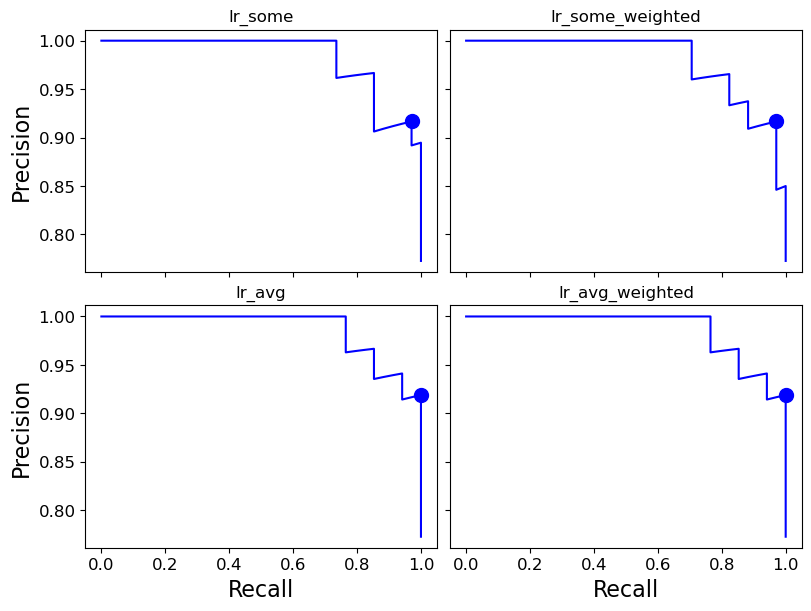

In [19]:
# Here we'll plot some precision-recall curves

from sklearn.metrics import precision_recall_curve

def get_probs(model, X_test):
    y_probs = model.predict_proba(X_test)[:,1]
    return y_probs

models = [lr_some, lr_some_weighted, lr_avg, lr_avg_weighted]
model_strs = ['lr_some', 'lr_some_weighted', 'lr_avg', 'lr_avg_weighted']
X_tests = [X_test_some, X_test_some_weighted, X_test_avg, X_test_avg_weighted]
y_probs = [get_probs(x,y) for x,y in zip(models,X_tests)]
y_tests = [y_test_some, y_test_some_weighted, y_test_avg, y_test_avg_weighted]

fig, axes = plt.subplots(2, 2, figsize=(8,6), sharey=True, sharex=True, constrained_layout=True)

for i in range(len(models)):

    prec_test, rec_test, thresh_test = precision_recall_curve(y_tests[i], y_probs[i])

    opt_prec, opt_rec, opt_thresh, _ = optimal_threshold(prec_test, rec_test, thresh_test)

    
    axes[math.floor(i/2), i%2].plot(rec_test, prec_test, 'b')
    axes[math.floor(i/2), i%2].plot(opt_rec, opt_prec, 'ob', markersize=10)
    axes[math.floor(i/2), i%2].set(title=model_strs[i])
    #axes[math.floor(i/2), i%2].set_yticks([0, 1])
    axes[math.floor(i/2), i%2].tick_params(axis = 'both', labelsize=12)
    if i%2==0:
        axes[math.floor(i/2), i%2].set_ylabel('Precision', fontsize=16)
    if math.floor(i/2)==1:
        axes[math.floor(i/2), i%2].set_xlabel('Recall', fontsize=16)

    print(f'Optimal probability threshold for model {model_strs[i]}: {opt_thresh:.3}')

**Brief analysis**: These all look about the same. Let's start visualizing predictions.

Text(0, 0.5, 'Pass Probability')

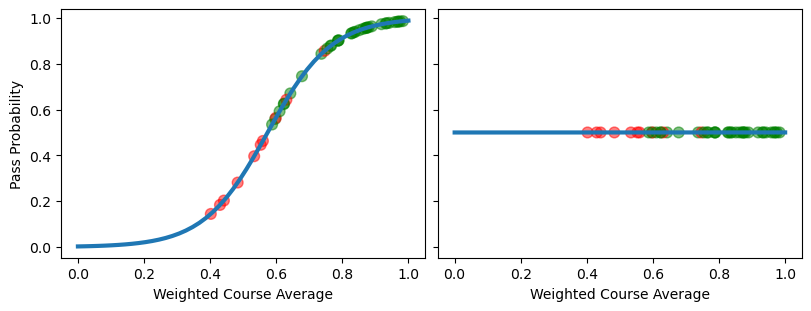

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(8,3), sharey=True, constrained_layout=True)
colormap = np.array(['r', 'g'])

avg_models = [lr_avg, lr_avg_weighted]
X_tests_avg = [X_test_avg, X_test_avg_weighted]
y_probs_avg = [get_probs(x,y) for x,y in zip(avg_models,X_tests_avg)]
y_tests_avg = [y_test_avg, y_test_avg_weighted]

X_range = np.linspace(0,1,50).reshape(-1,1)
get_probs(lr_avg,X_range)
y_probs_range_avg = [get_probs(x,y) for x,y in zip(avg_models,[X_range, X_range])]

for i, z in enumerate(y_probs_range_avg):
    axes[i].plot(X_range,z,linewidth=3)
    axes[i].scatter(X_tests_avg[i], y_probs_avg[i],c=colormap[y_tests_avg[i]],alpha=0.5,s=60)
    axes[i].set_xlabel('Weighted Course Average')
    
axes[0].set_ylabel('Pass Probability')
    


**Brief analysis**: Alright, something fishy here. The model trained with class weights gives every student a ~50% chance of passing. Maybe the model was too regularized? Might be wroth looking into, but the un-weighted model works well enough for out purposes.

In [21]:
'''
import numpy as np
N = 200
x = np.linspace(0, 1, N)
x1, x2 = np.meshgrid(x, x)
P_prob = np.zeros((N,N))
P_pred = np.zeros((N,N))

for i in range(N):
    for j in range(N):
        dat = pd.DataFrame(data = {'Midterm1': [x[j]], 'Quiz Avg': [x[i]]})
        
        P_prob[i, j] = np.squeeze(clf.predict_proba(dat)[:,1])
        P_pred[i, j] = np.squeeze((clf.predict_proba(dat)[:,1]>0.5)*1)

print(P_prob)
plt.imshow(P_prob, origin = 'lower')
plt.colorbar()
plt.show()
'''

"\nimport numpy as np\nN = 200\nx = np.linspace(0, 1, N)\nx1, x2 = np.meshgrid(x, x)\nP_prob = np.zeros((N,N))\nP_pred = np.zeros((N,N))\n\nfor i in range(N):\n    for j in range(N):\n        dat = pd.DataFrame(data = {'Midterm1': [x[j]], 'Quiz Avg': [x[i]]})\n        \n        P_prob[i, j] = np.squeeze(clf.predict_proba(dat)[:,1])\n        P_pred[i, j] = np.squeeze((clf.predict_proba(dat)[:,1]>0.5)*1)\n\nprint(P_prob)\nplt.imshow(P_prob, origin = 'lower')\nplt.colorbar()\nplt.show()\n"

In [22]:
'''
curve50 = np.argmin(abs(P_prob-0.5), axis = 0)
print(x[curve50==0])
curve30 = np.argmin(abs(P_prob-0.3), axis = 0)
curve70 = np.argmin(abs(P_prob-0.7), axis = 0)

fig, ax = plt.subplots(figsize=(6,6))
ax.imshow(P_pred, origin = 'lower', alpha = 0.5, extent=[0,1,0,1], interpolation='none', aspect = 'auto')
#plt.scatter(train_data['Midterm1'], train_data['Quiz Avg'], c = c_train, alpha = 0.5, s = 50)
plt.scatter(pred_data['Midterm1'], pred_data['Quiz Avg'], c = c_pred, alpha = 1, s = 60, marker = '*')
plt.scatter(pred_wrong['Midterm1'], pred_wrong['Quiz Avg'], c = c_pred_wrong, alpha = 1, s = 80, marker = '*')
plt.plot(x, curve50/200)
plt.plot(x, curve30/200)
plt.plot(x, curve70/200)
#plt.colorbar()
plt.xlabel('Midterm 1 Score', fontsize = 14)
plt.ylabel('Early Quiz Average', fontsize = 14)
plt.show()
'''

"\ncurve50 = np.argmin(abs(P_prob-0.5), axis = 0)\nprint(x[curve50==0])\ncurve30 = np.argmin(abs(P_prob-0.3), axis = 0)\ncurve70 = np.argmin(abs(P_prob-0.7), axis = 0)\n\nfig, ax = plt.subplots(figsize=(6,6))\nax.imshow(P_pred, origin = 'lower', alpha = 0.5, extent=[0,1,0,1], interpolation='none', aspect = 'auto')\n#plt.scatter(train_data['Midterm1'], train_data['Quiz Avg'], c = c_train, alpha = 0.5, s = 50)\nplt.scatter(pred_data['Midterm1'], pred_data['Quiz Avg'], c = c_pred, alpha = 1, s = 60, marker = '*')\nplt.scatter(pred_wrong['Midterm1'], pred_wrong['Quiz Avg'], c = c_pred_wrong, alpha = 1, s = 80, marker = '*')\nplt.plot(x, curve50/200)\nplt.plot(x, curve30/200)\nplt.plot(x, curve70/200)\n#plt.colorbar()\nplt.xlabel('Midterm 1 Score', fontsize = 14)\nplt.ylabel('Early Quiz Average', fontsize = 14)\nplt.show()\n"

## Below I define functions that look up the students with the closest averages to an input average and functions that plot passing probabilities

In [23]:

def find_closest_1D(new_weighted_avg, num_closest, X_weighted_avg, y):

    '''
    Returns num_closest students from the ODE grade dataset with the closest weighted course averages to new_weighted_avg

    Arguments:
        new_weighted_average - weighted course average of a new student (for prediction)
        num_closest - the number of the closest datapoints to return
        X_weighted_avg - 'Weighted Avg' column from the X dataframe
        y - target vector of 0 and 1's corresponding to fail and pass
    Returns:
        Dataframe of closest datapoints and pass/fail data
    '''

    k_closest_idx = np.argpartition(np.abs(X_weighted_avg-new_weighted_avg), num_closest)[:num_closest]

    df_closest = pd.DataFrame()
    df_closest.insert(0, column = 'Weighted Avg', value = X_weighted_avg[k_closest_idx])
    df_closest.insert(1, column = 'Passed', value = ['Yes' if x==1 else 'No' for x in y[k_closest_idx]])
    df_closest.sort_values(by = ['Weighted Avg'], axis=0, inplace=True)
    return df_closest.reset_index(drop=True)



In [24]:
new_avg = 0.7
df_closest1 = find_closest_1D(new_avg, 10, X['Weighted Avg'], y)
df_closest1

,Weighted Avg,Passed
0,0.680208,Yes
1,0.683333,Yes
2,0.696667,Yes
3,0.697083,Yes
4,0.697917,Yes
5,0.700833,Yes
6,0.712917,No
7,0.717014,Yes
8,0.717157,Yes
9,0.718333,No


In [25]:

def find_closest_2D(new_midterm1, new_quiz_avg, num_closest, X_some, y):

    '''
    Returns num_closest students from the ODE grade dataset with the closest (in Euclidean distance) weighted course averages to new_weighted_avg

    Arguments:
        new_midterm1 - midterm 1 score of a new student (for prediction)
        new_quiz_average -  quiz average of a new student (for prediction)
        num_closest - the number of the closest datapoints to return
        X_weighted_avg - 'Weighted Avg' column from the X dataframe
        y - target vector of 0 and 1's corresponding to fail and pass
    Returns:
        Dataframe of closest datapoints and pass/fail data
    '''

    k_closest_idx = np.argpartition(np.abs(X_some['Quiz Avg']-new_quiz_avg)**2 + (np.abs(X_some['Midterm1']-new_midterm1)**2), num_closest)[:num_closest]

    df_closest = pd.DataFrame()
    df_closest.insert(0, column = 'Midterm1', value = X_some['Midterm1'].iloc[k_closest_idx])
    df_closest.insert(1, column = 'Quiz Avg', value = X_some['Quiz Avg'].iloc[k_closest_idx])
    df_closest.insert(2, column = 'Passed', value = ['Yes' if x==1 else 'No' for x in y[k_closest_idx]])
    df_closest.insert(3, column = 'Dist', value = np.abs(X_some['Quiz Avg']-new_quiz_avg)**2 + (np.abs(X_some['Midterm1']-new_midterm1)**2))
    df_closest.sort_values(by = ['Dist'], axis=0, inplace=True)
    return df_closest.drop('Dist', axis=1).reset_index(drop=True)

In [26]:
new_quiz_avg = 0.3
new_mid1 = .4
df_closest2 = find_closest_2D(new_mid1, new_quiz_avg, 10, X[['Quiz Avg', 'Midterm1']], y)
df_closest2

,Midterm1,Quiz Avg,Passed
0,0.425926,0.331944,No
1,0.388889,0.251944,No
2,0.375000,0.233333,No
3,0.352941,0.366667,No
4,0.333333,0.233333,No
5,0.416667,0.400000,No
6,0.479167,0.233333,No
7,0.435897,0.400000,No
8,0.541667,0.400000,No
9,0.407407,0.498611,No


In [27]:
def plot_prediction_1D(model, new_weighted_avg, X_weighted_avg, y):
    '''
    Returns figure of passing probabilities and the outcomes of the 50 closest past students

    Arguments:
        model - trained model to use
        new_weighted_average -  weight course average of a new student (for prediction)
        X_weighted_avg - 'Weighted Avg' column from the X dataframe
        y - target vector of 0 and 1's corresponding to fail and pass
    Returns:
        Dataframe of closest datapoints and pass/fail data
    '''
    X_range = np.linspace(0,1,50).reshape(-1,1)
    y_probs_range = model.predict_proba(X_range)[:,1]
    
    closest = find_closest_1D(new_weighted_avg, 10, X_weighted_avg, y)
    closest_probs = model.predict_proba(closest[['Weighted Avg']])[:,1]
    closest_passed = (closest['Passed'].values=='Yes')*1
    new_pass_proba = model.predict_proba([[new_weighted_avg]])[0,1]
    
    colormap = np.array(['r', 'g'])

    fig = plt.figure(figsize=(4,3))
    plt.plot(X_range,y_probs_range,linewidth=3)
    #plt.scatter(closest['Weighted Avg'], closest_passed, c=colormap[closest_passed], alpha=0.5, s=50)
    plt.plot(new_weighted_avg, new_pass_proba, 'o', c='tab:red', markersize=10)
    plt.plot([new_weighted_avg, new_weighted_avg], [0, new_pass_proba], '--', c='tab:red')
    plt.plot([0, new_weighted_avg], [new_pass_proba, new_pass_proba], '--', c='tab:red')
    plt.xlabel('Weighted Course Average') 
    plt.ylabel('Pass Probability')
    plt.xlim(0, 1)
    plt.ylim(0, 1)

    return fig

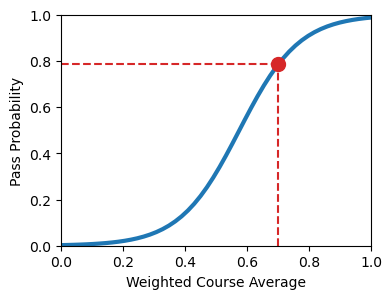

In [28]:

fig1 = plot_prediction_1D(lr_avg, new_avg, X['Weighted Avg'], y)

In [29]:
def plot_prediction_2D(model, new_midterm1, new_quiz_avg, X_some, y):
    '''
    Returns figure of passing probabilities and the outcomes of the 50 closest past students

    Arguments:
        model - trained model to use
        new_midterm1 - midterm 1 score of a new student (for prediction)
        new_quiz_average -  quiz average of a new student (for prediction)
        X_weighted_avg - 'Weighted Avg' column from the X dataframe
        y - target vector of 0 and 1's corresponding to fail and pass
    Returns:
        Dataframe of closest datapoints and pass/fail data
    '''
    N = 200
    x = np.linspace(0, 1, N)
    x1, x2 = np.meshgrid(x, x)
    P_prob = np.zeros((N,N))

    closest = find_closest_2D(new_midterm1, new_quiz_avg, 50, X_some, y)
    closest_probs = model.predict_proba(closest[['Midterm1', 'Quiz Avg']])[:,1]
    closest_passed = (closest['Passed'].values=='Yes')*1

    new_pass_proba = model.predict_proba([[new_midterm1, new_quiz_avg]])[0,1]

    colormap = np.array(['r', 'g'])

    for i in range(N):
        for j in range(N):
            #dat = pd.DataFrame(data = {'Midterm1': [x[j]], 'Quiz Avg': [x[i]]})
            P_prob[i, j] = model.predict_proba([[x[j],x[i]]])[0,1]

    #plt.subsplots()
    from matplotlib.colors import ListedColormap
    fig = plt.figure(figsize=(6,4))
    im = plt.imshow(P_prob, origin = 'lower', extent = [0, 1, 0, 1], alpha=0.5)
    colormap1 = ListedColormap(['r', 'g'])
    colormap2 = ListedColormap(['b'])
    #scatter = plt.scatter(X['Quiz Avg'], X['Midterm1'],c=y.values,cmap=colormap)
    scatter1 = plt.scatter(closest['Midterm1'], closest['Quiz Avg'], c=closest_passed, cmap=colormap1, alpha=1, s=30)
    scatter2 = plt.scatter(new_midterm1, new_quiz_avg, c=[0], cmap=colormap2, s=150)
    plt.xlabel('Midterm 1 Score', fontsize=14)
    plt.ylabel('Quiz Average', fontsize=14)
    cbar = plt.colorbar(im, alpha=0.5)
    cbar.set_label('Pass probability', fontsize=14)
    #handles, labels = .legend_elements()
    plt.legend(handles=scatter1.legend_elements()[0][::-1] + scatter2.legend_elements()[0], labels=['Pass','Fail','Your scores'], fontsize=9, loc='lower center', ncol=3)
    
    return fig


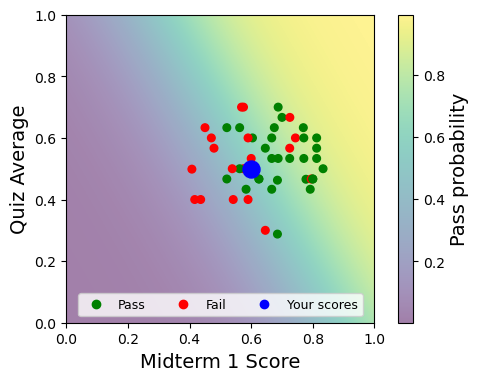

In [30]:
fig2 = plot_prediction_2D(lr_some, .6, .5, X[['Quiz Avg', 'Midterm1']], y)

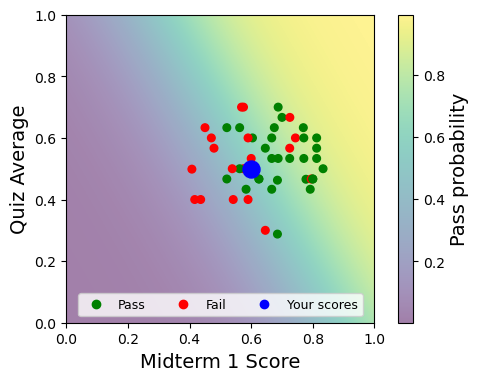

In [31]:
fig2